In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
# 데이터셋 준비
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [8]:
train_dataset.data .shape

torch.Size([60000, 28, 28])

In [9]:
train_loader.dataset.data[0].shape

torch.Size([28, 28])

In [10]:
train_loader.batch_size

64

In [3]:
for x, y in train_loader:
    print(x.shape)  # 출력: torch.Size([64, 1, 28, 28])
    break

torch.Size([64, 1, 28, 28])


In [5]:
# 간단한 모델 정의
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    # x.shape = [64, 1, 28, 28]  # 배치 크기 64
    # x.view(-1, 28*28) → shape: [64, 784]
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN()
model

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# 훈련 및 검증 기록을 위한 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# 모델 훈련 함수
def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # loss.item()은 미니 배치의 평균 손실을 제공하기 때문에,
        # 전체 데이터셋에 대한 손실을 계산하려면 batch_size를 곱함
        running_loss += loss.item() * inputs.size(0) # input : (batch_size(64), 784)

        # predicted : index value of Max -> predicted label
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    return running_loss / total, correct / total

In [ ]:
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    average_loss = running_loss / total
    accuracy = correct / total

    return average_loss, accuracy

In [16]:
# 훈련 루프
epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.3878, Train Acc: 0.8856
Val Loss: 0.2320, Val Acc: 0.9338
Epoch 2/10
Train Loss: 0.1965, Train Acc: 0.9424
Val Loss: 0.1512, Val Acc: 0.9558
Epoch 3/10
Train Loss: 0.1399, Train Acc: 0.9587
Val Loss: 0.1339, Val Acc: 0.9583
Epoch 4/10
Train Loss: 0.1137, Train Acc: 0.9660
Val Loss: 0.1212, Val Acc: 0.9615
Epoch 5/10
Train Loss: 0.0968, Train Acc: 0.9704
Val Loss: 0.1045, Val Acc: 0.9687
Epoch 6/10
Train Loss: 0.0840, Train Acc: 0.9742
Val Loss: 0.0974, Val Acc: 0.9686
Epoch 7/10
Train Loss: 0.0773, Train Acc: 0.9762
Val Loss: 0.0976, Val Acc: 0.9725
Epoch 8/10
Train Loss: 0.0690, Train Acc: 0.9780
Val Loss: 0.0967, Val Acc: 0.9706
Epoch 9/10
Train Loss: 0.0632, Train Acc: 0.9801
Val Loss: 0.0815, Val Acc: 0.9754
Epoch 10/10
Train Loss: 0.0570, Train Acc: 0.9821
Val Loss: 0.0946, Val Acc: 0.9727


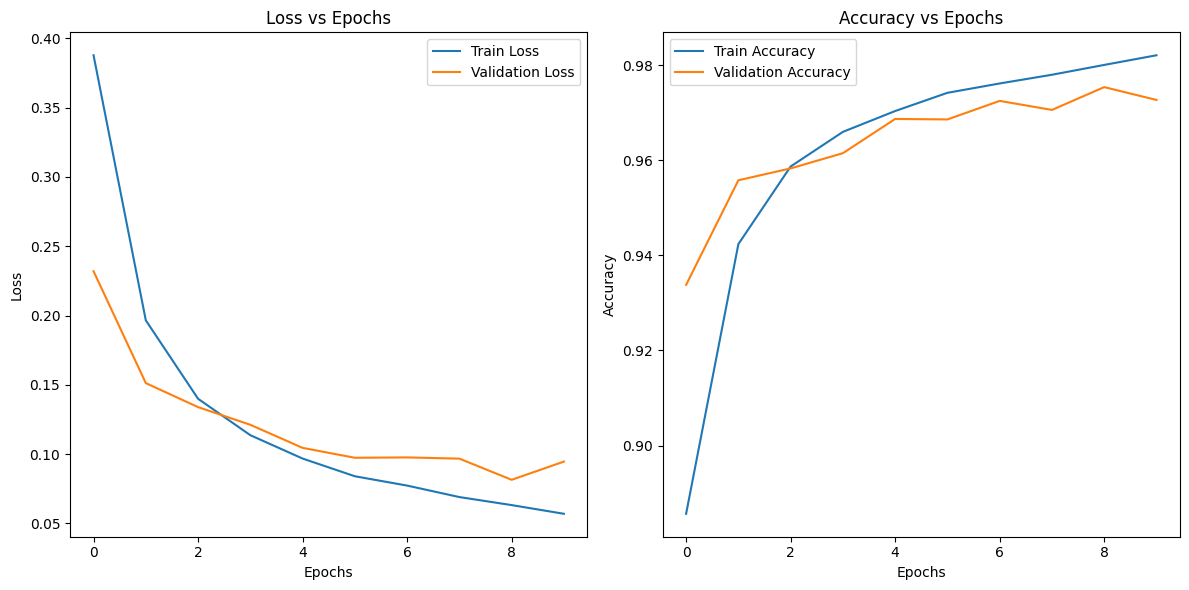

In [17]:
# 시각화
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

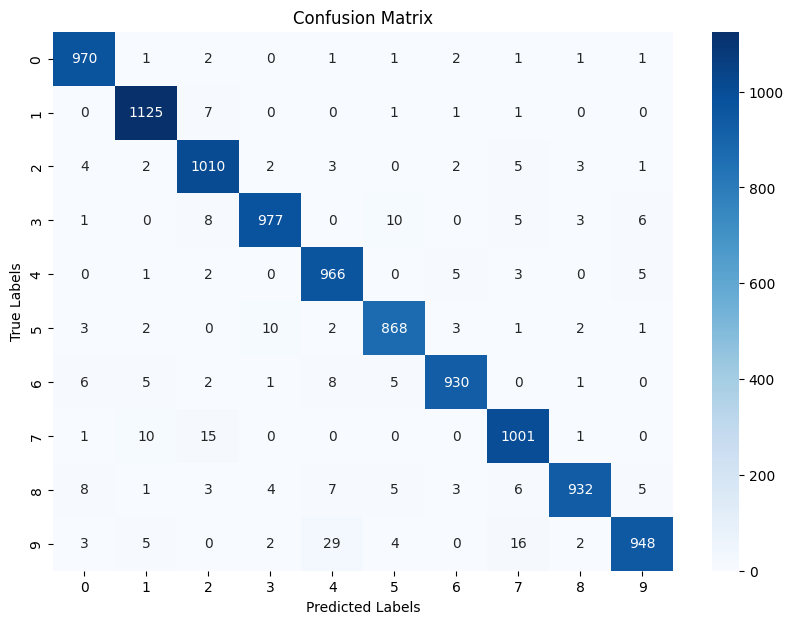

Validation Loss: 0.0946
Validation Accuracy: 0.9727


In [22]:
def validate_with_confusion_matrix(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    average_loss = running_loss / total
    accuracy = correct / total

    # Confusion Matrix 계산
    conf_mat = confusion_matrix(all_targets, all_preds)

    # Confusion Matrix 시각화
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return average_loss, accuracy, conf_mat

criterion = nn.CrossEntropyLoss()
average_loss, accuracy, conf_mat = validate_with_confusion_matrix(model, val_loader, criterion)
print(f"Validation Loss: {average_loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
